In [2]:
# comparison of cell viability CTG and cell count microscope

import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

#cpdata= pd.read_csv(r"C:\Users\Roman\OneDrive - National University of Ireland, Galway\CellPainting project data\wellProfilesHarmonyMean.csv")
#cpmetadata = pd.read_csv(r"C:\Users\Roman\OneDrive - National University of Ireland, Galway\CellPainting project data\ProfilesMADHarm.csv")

"""
cpdata['PlateNumber'] = cpdata['PlateName'].str[-1]
#cpdata = cpdata.filter(['Drug','Concentration','Cell Count'])
cpdata = cpdata.filter(['Row','Column','Concentration','Cell count'])
cpdata['Drug'] = cpmetadata['Drug']
#cpdata = cpdata[cpdata.PlateName.str.startswith('blast')]
cpdata = cpdata.groupby(by=['Drug','Concentration']).mean()
cpdata"""

"\ncpdata['PlateNumber'] = cpdata['PlateName'].str[-1]\n#cpdata = cpdata.filter(['Drug','Concentration','Cell Count'])\ncpdata = cpdata.filter(['Row','Column','Concentration','Cell count'])\ncpdata['Drug'] = cpmetadata['Drug']\n#cpdata = cpdata[cpdata.PlateName.str.startswith('blast')]\ncpdata = cpdata.groupby(by=['Drug','Concentration']).mean()\ncpdata"

In [3]:
cpdata_raw = pd.read_csv("E:/OneDrive - National University of Ireland, Galway/CellPainting project data/Harmony/Nv6-PerWell/blastsProfiles.csv").drop(['Unnamed: 0'],axis=1)
# cpdata = pd.read_csv("E:/OneDrive - National University of Ireland, Galway/CellPainting project data/Harmony/Nv6-PerWell/tubesProfilesNormalized.csv")
cpdata = cpdata_raw.copy()
cpdata.rename(columns={"Metadata_Object_Count":"Cell number"},inplace=True)
cpdata.sort_values(['Compound','Concentration'], inplace=True)

countMin = 0

cpdata['Count'] = cpdata['Count']/5                         # average count per field instead of well, no field missing
cpdata['Replicate'] = cpdata['PlateName'].str[-1]  
         # replicate number
controls = cpdata.loc[cpdata['Compound']=='DMSO']
controls.set_index(['PlateName','Compound'],inplace=True)
controlsMedian = controls.groupby(by=['Compound','Concentration','PlateName']).median(numeric_only=True).reset_index(drop=False)
#normalization of cpdata counts to DMSO median
for plate in cpdata.PlateName.unique():
    cpdata.loc[cpdata['PlateName']==plate,'Count'] = 100 * cpdata.loc[cpdata['PlateName']==plate,'Count'] / controlsMedian.loc[controlsMedian['PlateName']==plate,'Count'].values[0]
cpdata['Count'] = cpdata['Count'].round(decimals=3)
#cpdata = cpdata.loc[cpdata['Compound']!='DMSO']
cpdata['DataType'] = 'Cell count'
#cpdata.loc[cpdata['Compound']=='DMSO']
cpdata

,Row,Column,Compound,Concentration,PlateName,Count,Cell 33342 Radial Mean,Cell 33342 Radial Mean Ratio SER-Bright,Cell 33342 Radial Mean Ratio SER-Dark,Cell 33342 Radial Mean Ratio SER-Edge,Cell 33342 Radial Mean Ratio SER-Hole,Cell 33342 Radial Mean Ratio SER-Ridge,Cell 33342 Radial Mean Ratio SER-Saddle,Cell 33342 Radial Mean Ratio SER-Spot,Cell 33342 Radial Mean Ratio SER-Valley,Cell 33342 Radial Mean SER-Bright,Cell 33342 Radial Mean SER-Dark,Cell 33342 Radial Mean SER-Edge,Cell 33342 Radial Mean SER-Hole,Cell 33342 Radial Mean SER-Ridge,Cell 33342 Radial Mean SER-Saddle,Cell 33342 Radial Mean SER-Spot,Cell 33342 Radial Mean SER-Valley,Cell 33342 Radial Relative Deviation,Cell 33342 Radial Relative Deviation SER-Bright,Cell 33342 Radial Relative Deviation SER-Dark,Cell 33342 Radial Relative Deviation SER-Edge,Cell 33342 Radial Relative Deviation SER-Hole,Cell 33342 Radial Relative Deviation SER-Ridge,Cell 33342 Radial Relative Deviation SER-Saddle,Cell 33342 Radial Relative Deviation SER-Spot,Cell 33342 Radial Relative Deviation SER-Valley,Cell 488 Axial Length Ratio,Cell 488 Axial Length Ratio SER-Bright,Cell 488 Axial Length Ratio SER-Dark,Cell 488 Axial Length Ratio SER-Edge,Cell 488 Axial Length Ratio SER-Hole,Cell 488 Axial Length Ratio SER-Ridge,Cell 488 Axial Length Ratio SER-Saddle,Cell 488 Axial Length Ratio SER-Spot,...,Nucleus Mito Profile 4/5 SER-Valley,Nucleus Mito Profile 5/5,Nucleus Mito Profile 5/5 SER-Bright,Nucleus Mito Profile 5/5 SER-Dark,Nucleus Mito Profile 5/5 SER-Edge,Nucleus Mito Profile 5/5 SER-Hole,Nucleus Mito Profile 5/5 SER-Ridge,Nucleus Mito Profile 5/5 SER-Saddle,Nucleus Mito Profile 5/5 SER-Spot,Nucleus Mito Profile 5/5 SER-Valley,Nucleus Ratio Width to Length,Nucleus Roundness,Nucleus Width [µm],Object No in All cells no border,Ring Region Alexa 488 SER Bright 0 px,Ring Region Alexa 488 SER Dark 0 px,Ring Region Alexa 488 SER Edge 0 px,Ring Region Alexa 488 SER Hole 0 px,Ring Region Alexa 488 SER Ridge 0 px,Ring Region Alexa 488 SER Saddle 0 px,Ring Region Alexa 488 SER Spot 0 px,Ring Region Alexa 488 SER Valley 0 px,Ring Region Alexa 568 SER Bright 0 px,Ring Region Alexa 568 SER Dark 0 px,Ring Region Alexa 568 SER Edge 0 px,Ring Region Alexa 568 SER Hole 0 px,Ring Region Alexa 568 SER Ridge 0 px,Ring Region Alexa 568 SER Saddle 0 px,Ring Region Alexa 568 SER Spot 0 px,Ring Region Alexa 568 SER Valley 0 px,Ring Region Alexa 647 SER Bright 0 px,Ring Region Alexa 647 SER Dark 0 px,Ring Region Alexa 647 SER Edge 0 px,Ring Region Alexa 647 SER Hole 0 px,Ring Region Alexa 647 SER Ridge 0 px,Ring Region Alexa 647 SER Saddle 0 px,Ring Region Alexa 647 SER Spot 0 px,Ring Region Alexa 647 SER Valley 0 px,Replicate,DataType
44,5,7,ATOR,10,blasts1-BR1,99.377,-0.032514,1.306296,-0.338065,-0.103579,0.344815,1.273583,0.350626,1.284041,-0.342394,0.410970,-0.189054,-0.062399,0.275769,0.325797,0.192490,0.310485,-0.371876,2.429620,2.232829,0.841581,1.751484,0.135159,2.183740,1.749042,2.271808,0.943410,-2.177905,-2.122369,-2.358794,-1.902220,-2.092622,-2.162986,-2.014394,-1.943408,...,0.343586,-0.203180,0.234005,-0.175002,-0.063484,-0.057801,0.436630,-0.047941,-0.060379,-0.205654,-0.090668,-0.044605,-0.879689,-0.388192,1.676092,1.625657,-0.430382,2.483074,0.730619,-0.188931,2.321713,0.716623,1.639822,1.746982,2.310786,1.316283,2.045903,1.910481,0.620997,2.266686,0.633854,0.721269,0.192930,0.820240,0.459460,0.337330,0.774428,0.565948,1,Cell count
45,5,8,ATOR,10,blasts1-BR1,99.153,1.072954,0.586500,-0.705328,-1.424406,0.499293,0.641717,0.419021,0.421105,-0.839202,0.804605,0.486231,0.284815,0.961859,0.872837,1.210854,1.270628,0.353798,1.146840,1.339216,0.942579,1.203964,-0.951885,1.558159,0.882095,1.500848,0.952945,-1.279653,-2.342018,-1.043880,-1.645903,-0.926870,-2.134493,-1.490585,-2.126629,...,-0.520279,-0.468768,-0.802808,-1.523928,-1.271112,-2.165714,-0.867366,-1.174294,-0.983848,-1.329064,-0.474079,-0.087321,-0.879689,-0.388192,1.044514,2.030746,-0.667828,3.020047,-0.058091,-0.598191,2.173482,0.574266,1.

In [4]:
# duplicate DMSO rows in each plate and replace compound name of DMSO to drug names to plot them as Vehicle 0nM
from numpy.core import numeric


cp_data_with_dmso_as_drug = cpdata.copy()
for PlateName in cpdata.PlateName.unique():
    temp_df = cpdata.loc[cpdata['PlateName']==PlateName]
    for compound in temp_df.Compound.unique():
        if compound != 'DMSO':
            new_dmso = temp_df.loc[temp_df['Compound']=='DMSO']
            new_dmso.loc[:,'Compound'] = compound
            new_dmso = new_dmso.groupby(by=['PlateName','Compound','Replicate','DataType']).mean().reset_index(drop=False) #1 value per plate
            cp_data_with_dmso_as_drug = pd.concat([cp_data_with_dmso_as_drug,new_dmso],ignore_index=True)
cp_data_with_dmso_as_drug.drop(cp_data_with_dmso_as_drug.loc[cp_data_with_dmso_as_drug['Compound']=='DMSO'].index,inplace=True)
cp_data_with_dmso_as_drug.sort_values(['Compound','Concentration', 'PlateName'],inplace=True)
cp_data_with_dmso_as_drug

,Row,Column,Compound,Concentration,PlateName,Count,Cell 33342 Radial Mean,Cell 33342 Radial Mean Ratio SER-Bright,Cell 33342 Radial Mean Ratio SER-Dark,Cell 33342 Radial Mean Ratio SER-Edge,Cell 33342 Radial Mean Ratio SER-Hole,Cell 33342 Radial Mean Ratio SER-Ridge,Cell 33342 Radial Mean Ratio SER-Saddle,Cell 33342 Radial Mean Ratio SER-Spot,Cell 33342 Radial Mean Ratio SER-Valley,Cell 33342 Radial Mean SER-Bright,Cell 33342 Radial Mean SER-Dark,Cell 33342 Radial Mean SER-Edge,Cell 33342 Radial Mean SER-Hole,Cell 33342 Radial Mean SER-Ridge,Cell 33342 Radial Mean SER-Saddle,Cell 33342 Radial Mean SER-Spot,Cell 33342 Radial Mean SER-Valley,Cell 33342 Radial Relative Deviation,Cell 33342 Radial Relative Deviation SER-Bright,Cell 33342 Radial Relative Deviation SER-Dark,Cell 33342 Radial Relative Deviation SER-Edge,Cell 33342 Radial Relative Deviation SER-Hole,Cell 33342 Radial Relative Deviation SER-Ridge,Cell 33342 Radial Relative Deviation SER-Saddle,Cell 33342 Radial Relative Deviation SER-Spot,Cell 33342 Radial Relative Deviation SER-Valley,Cell 488 Axial Length Ratio,Cell 488 Axial Length Ratio SER-Bright,Cell 488 Axial Length Ratio SER-Dark,Cell 488 Axial Length Ratio SER-Edge,Cell 488 Axial Length Ratio SER-Hole,Cell 488 Axial Length Ratio SER-Ridge,Cell 488 Axial Length Ratio SER-Saddle,Cell 488 Axial Length Ratio SER-Spot,...,Nucleus Mito Profile 4/5 SER-Valley,Nucleus Mito Profile 5/5,Nucleus Mito Profile 5/5 SER-Bright,Nucleus Mito Profile 5/5 SER-Dark,Nucleus Mito Profile 5/5 SER-Edge,Nucleus Mito Profile 5/5 SER-Hole,Nucleus Mito Profile 5/5 SER-Ridge,Nucleus Mito Profile 5/5 SER-Saddle,Nucleus Mito Profile 5/5 SER-Spot,Nucleus Mito Profile 5/5 SER-Valley,Nucleus Ratio Width to Length,Nucleus Roundness,Nucleus Width [µm],Object No in All cells no border,Ring Region Alexa 488 SER Bright 0 px,Ring Region Alexa 488 SER Dark 0 px,Ring Region Alexa 488 SER Edge 0 px,Ring Region Alexa 488 SER Hole 0 px,Ring Region Alexa 488 SER Ridge 0 px,Ring Region Alexa 488 SER Saddle 0 px,Ring Region Alexa 488 SER Spot 0 px,Ring Region Alexa 488 SER Valley 0 px,Ring Region Alexa 568 SER Bright 0 px,Ring Region Alexa 568 SER Dark 0 px,Ring Region Alexa 568 SER Edge 0 px,Ring Region Alexa 568 SER Hole 0 px,Ring Region Alexa 568 SER Ridge 0 px,Ring Region Alexa 568 SER Saddle 0 px,Ring Region Alexa 568 SER Spot 0 px,Ring Region Alexa 568 SER Valley 0 px,Ring Region Alexa 647 SER Bright 0 px,Ring Region Alexa 647 SER Dark 0 px,Ring Region Alexa 647 SER Edge 0 px,Ring Region Alexa 647 SER Hole 0 px,Ring Region Alexa 647 SER Ridge 0 px,Ring Region Alexa 647 SER Saddle 0 px,Ring Region Alexa 647 SER Spot 0 px,Ring Region Alexa 647 SER Valley 0 px,Replicate,DataType
3351,8.5,4.5,ATOR,0.0,blasts1-BR1,100.137167,1.387779e-17,1.619075e-17,-9.251859e-18,-9.251859e-18,2.891206e-17,-4.625929e-18,2.688821e-17,4.625929e-18,9.251859e-18,-5.551115e-17,0.000000e+00,9.251859e-18,4.278985e-17,2.312965e-17,-1.619075e-17,4.625929e-18,9.251859e-18,-1.619075e-17,9.251859e-18,-3.238150e-17,6.938894e-18,2.775558e-17,6.938894e-18,-2.312965e-17,9.251859e-18,0.000000e+00,-4.625929e-18,6.013708e-17,2.775558e-17,4.625929e-18,4.625929e-18,1.850372e-17,4.625929e-18,2.081668e-17,...,-3.932040e-17,-1.850372e-17,-1.966020e-17,0.000000e+00,-2.312965e-17,-2.081668e-17,-9.251859e-18,-9.251859e-18,4.625929e-17,-2.312965e-17,-2.529805e-18,0.000000e+00,2.312965e-17,3.122502e-17,-2.891206e-17,2.833382e-17,1.619075e-17,-1.156482e-17,1.619075e-17,1.619075e-17,5.204170e-17,-1.734723e-17,-9.251859e-18,3.238150e-17,0.000000e+00,4.625929e-17,-3.700743e-17,9.251859e-18,4.625929e-17,-3.238150e-17,2.602085e-17,-2.544261e-17,1.850372e-17,2.081668e-17,-5.782412e-18,-6.938894e-18,5.204170e-18,4.770490e-17,1,Cell count
3357,8.5,5.0,ATOR,0.0,blasts1-BR2,99.455833,5.859510e-17,3.729655e-17,3.083953e-17,3.083953e-18,-5.242720e-17,-3.614007e-17,-1.541976e-17,-1.464878e-17,-1.541976e-17,4.625929e-18,4.934325e-17,-5.165621e-17,-2.852656e-17,1.773273e-17,3.392348e-17,3.932040e-17,-3.083953e-18,-4

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 3200x2400 with 0 Axes>

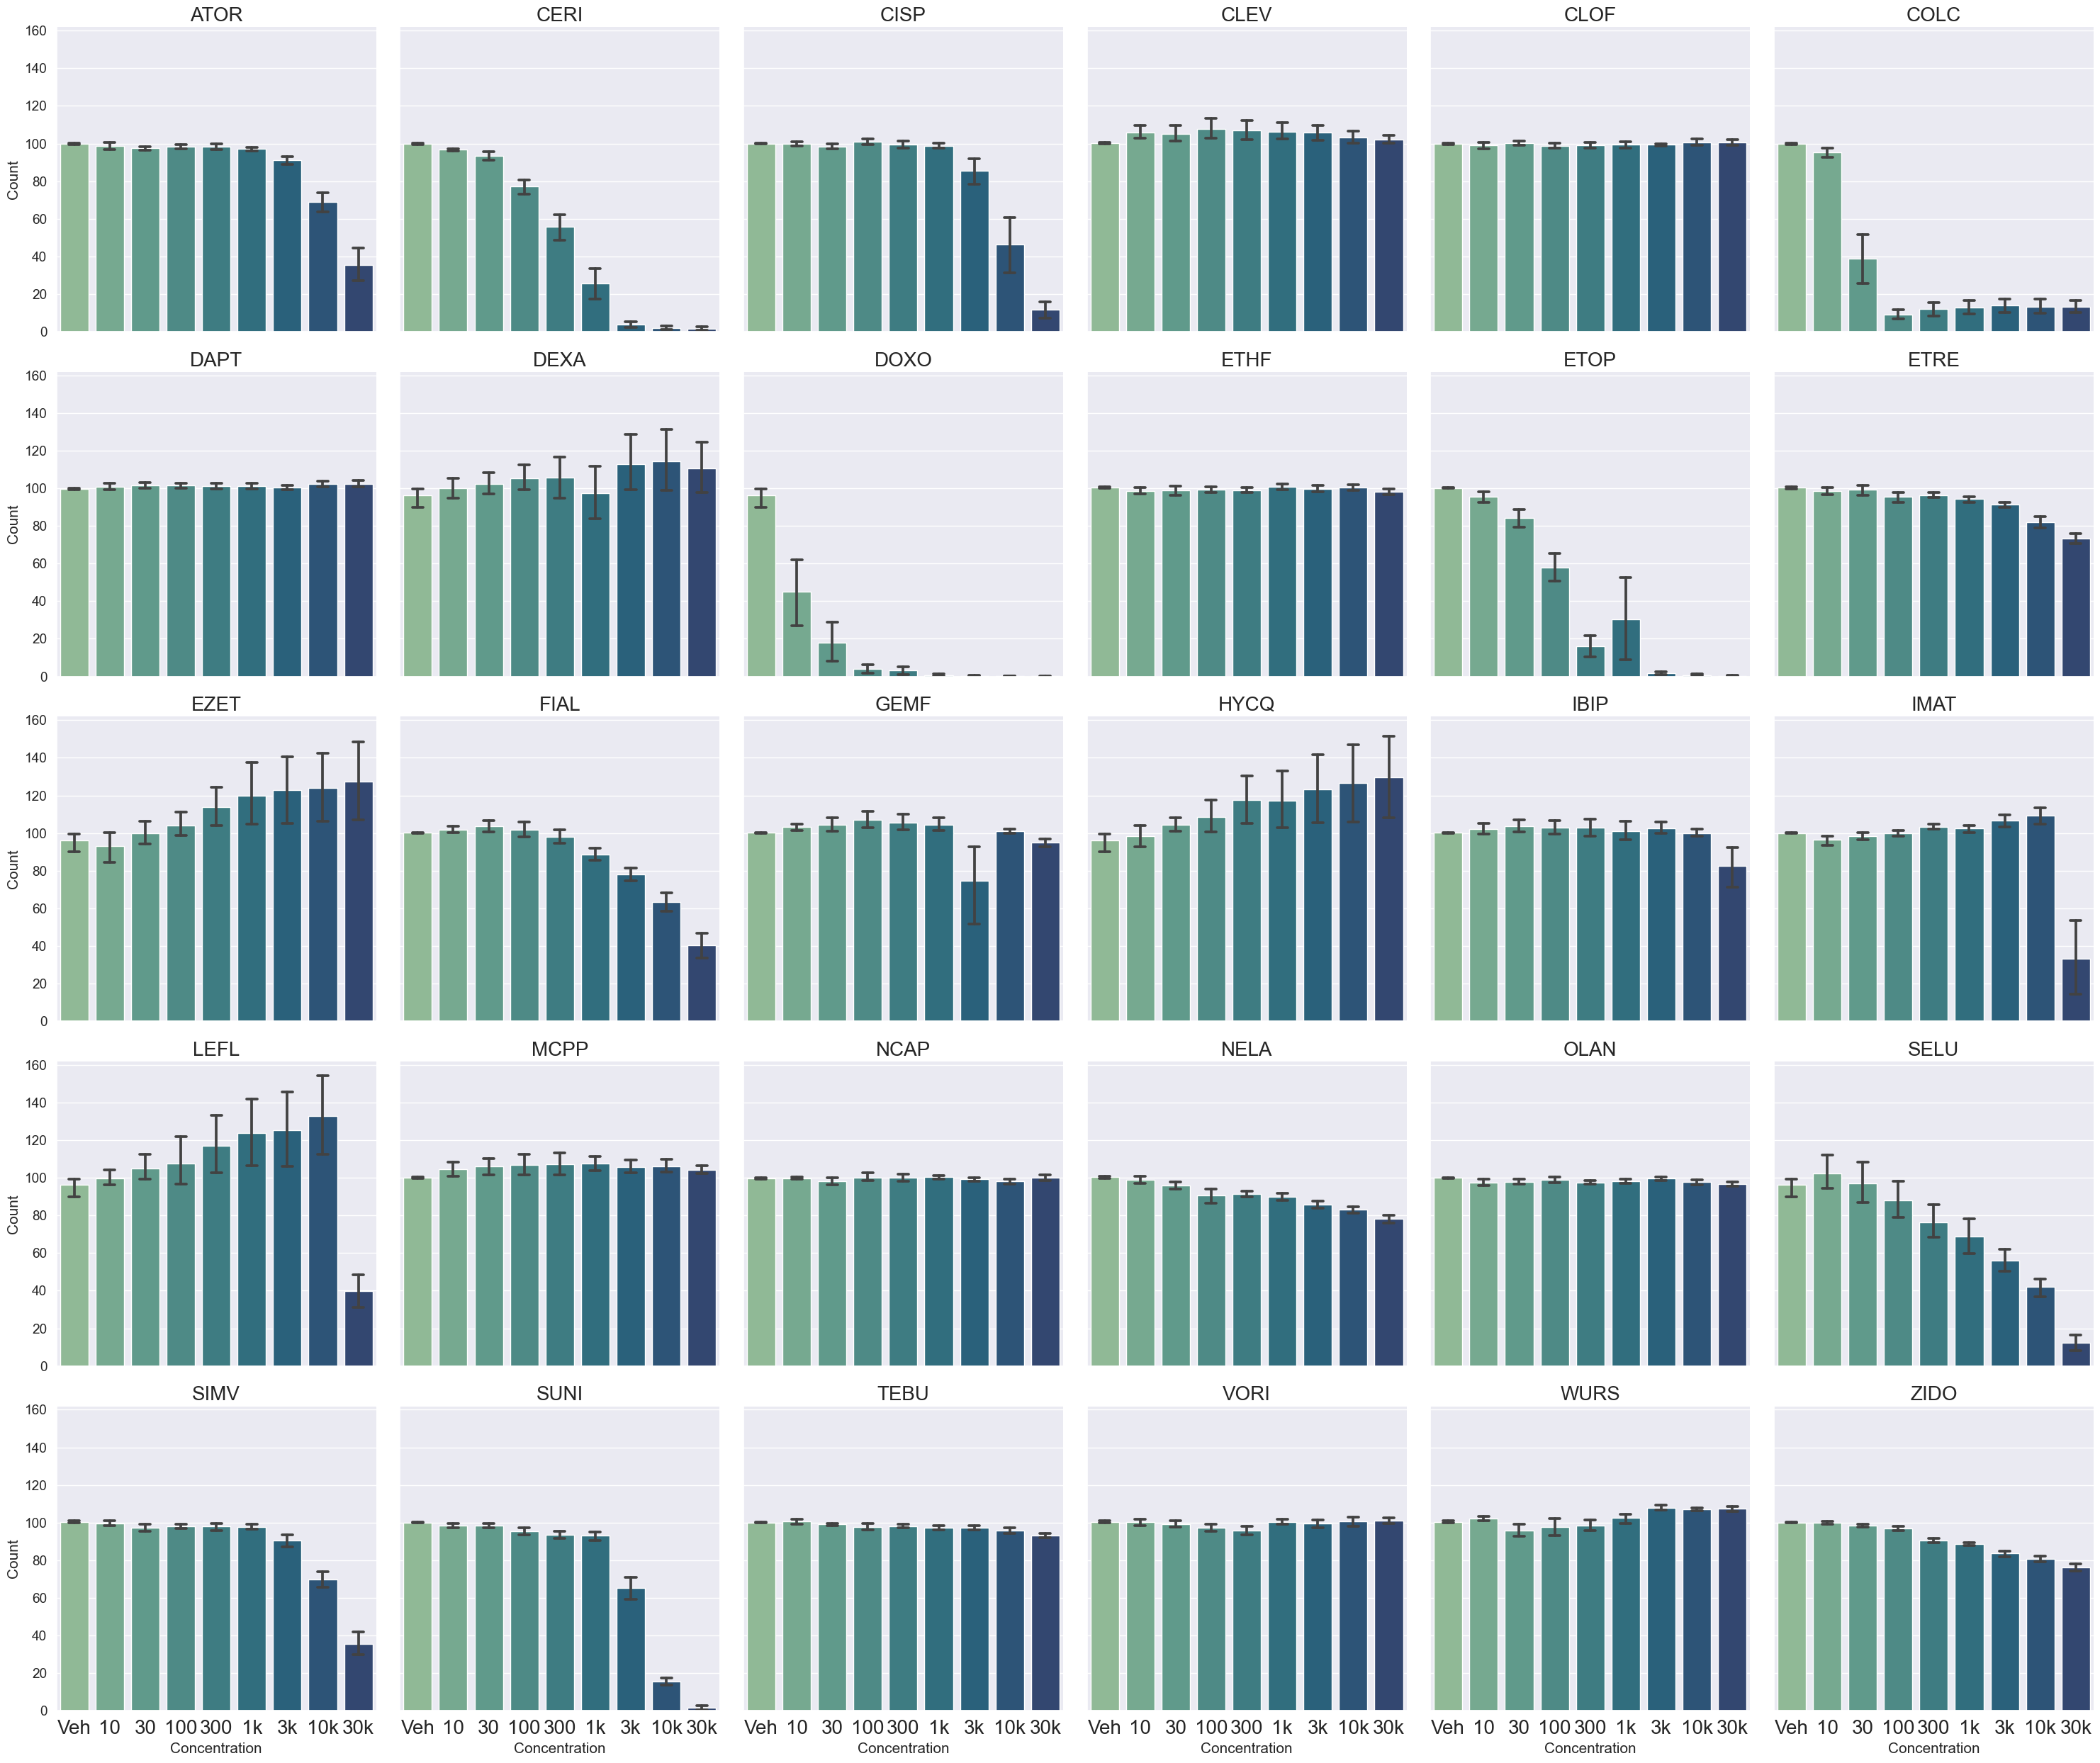

In [30]:
sns.set(font_scale=1.25)
plt.figure(dpi=500)
plotCP = sns.catplot(   data=cp_data_with_dmso_as_drug, 
                        x='Concentration',
                        y='Count',
                        col='Compound', 
                        #hue = 'Replicate', 
                        kind='bar',
                        palette = 'crest',
                        col_wrap=6,
                        capsize=0.3) # add hue='Replicate' to get individual replicates curves
plt.draw()
plotCP.set_titles(row_template = '{row_name}', col_template = '{col_name}',size=18)
plotCP.set_xticklabels(fontdict={'fontsize':20})
#plotCP.tick_params(axis='x', labelrotation = 0)
plotCP.set_xticklabels(['Veh','10','30','100','300','1k','3k','10k','30k'])
plotCP.set_titles(col_template = '{col_name}',size=20)

In [6]:
CTGdata = pd.read_csv(r"E:\OneDrive - National University of Ireland, Galway\plate reader\normCTGresultsUPCLIP.csv")
CTGdata = CTGdata[CTGdata['Plate'].str.contains("B")] # select cell type with B or T
#CTGdata = CTGdata[CTGdata['Compound']!= "DMSO"] #remove DMSO for graph
CTGdata.sort_values(['Compound','Concentration'], inplace=True)
CTGdata['Replicate'] = CTGdata['Plate'].str[0]
CTGdata.loc[((CTGdata['Replicate'] == 'g') & (CTGdata['Compound'].isin(['COLC','IMAT','SUNI','TEBU','OLAN','DOXO'])))]


,Compound,Concentration,Plate,Repeat,Cell Viability,Replicate
1004,COLC,10,gB1,1.0,91.546813,g
1005,COLC,30,gB1,1.0,85.315681,g
1006,COLC,100,gB1,1.0,89.279762,g
1007,COLC,300,gB1,1.0,100.662432,g
1008,COLC,1000,gB1,1.0,105.940377,g
1009,COLC,3000,gB1,1.0,107.144158,g
1010,COLC,10000,gB1,1.0,109.029843,g
1011,COLC,30000,gB1,1.0,112.506619,g
1038,DOXO,10,gB2,1.0,99.006392,g
1039,DOXO,30,gB2,1.0,89.942049,g


In [7]:

CTGdata.drop(CTGdata.loc[((CTGdata['Replicate']=='b') & (CTGdata['Compound'].isin(['COLC','ETOP','TEBU','OLAN','SUNI', 'IMAT'])))].index, axis=0, inplace=True)
#CTGdata.drop(CTGdata.loc[((CTGdata['Replicate'] == 'g') & (CTGdata['Compound'].isin(['COLC','IMAT','SUNI','TEBU','OLAN','DOXO'])))].index, axis=0, inplace=True)
CTGdata['DataType'] = 'Cell viability'
CTGdata

,Compound,Concentration,Plate,Repeat,Cell Viability,Replicate,DataType
0,ATOR,10,aB1,1.0,98.131926,a,Cell viability
490,ATOR,10,bB1,1.0,100.184183,b,Cell viability
980,ATOR,10,gB1,1.0,93.101075,g,Cell viability
1,ATOR,30,aB1,1.0,95.670780,a,Cell viability
491,ATOR,30,bB1,1.0,93.657161,b,Cell viability
...,...,...,...,...,...,...,...
733,ZIDO,10000,bB5,1.0,99.942803,b,Cell viability
1223,ZIDO,10000,gB5,1.0,100.021707,g,Cell viability
244,ZIDO,30000,aB5,1.0,82.919861,a,Cell viability
734,ZIDO,30000,bB5,1.0,100.551685,b,Cell viability


In [8]:
CTGdata_with_dmso_as_drug = CTGdata.copy()
for PlateName in CTGdata.Plate.unique():
    temp_df = CTGdata.loc[CTGdata['Plate']==PlateName]
    for compound in temp_df.Compound.unique():
        if compound != 'DMSO':
            new_dmso = temp_df.loc[temp_df['Compound']=='DMSO']
            new_dmso.loc[:,'Compound'] = compound
            new_dmso = new_dmso.groupby(by=['Plate','Compound','Replicate','DataType']).mean().reset_index(drop=False) #1 value per plate
            CTGdata_with_dmso_as_drug = pd.concat([CTGdata_with_dmso_as_drug,new_dmso],ignore_index=True)
CTGdata_with_dmso_as_drug.drop(CTGdata_with_dmso_as_drug.loc[CTGdata_with_dmso_as_drug['Compound']=='DMSO'].index,inplace=True)
CTGdata_with_dmso_as_drug.sort_values(['Compound','Concentration', 'Plate'],inplace=True)
CTGdata_with_dmso_as_drug

,Compound,Concentration,Plate,Repeat,Cell Viability,Replicate,DataType
687,ATOR,0.0,aB1,1.0,100.000000,a,Cell viability
693,ATOR,0.0,bB1,1.0,100.000000,b,Cell viability
698,ATOR,0.0,gB1,1.0,100.000000,g,Cell viability
0,ATOR,10.0,aB1,1.0,98.131926,a,Cell viability
1,ATOR,10.0,bB1,1.0,100.184183,b,Cell viability
...,...,...,...,...,...,...,...
682,ZIDO,10000.0,bB5,1.0,99.942803,b,Cell viability
683,ZIDO,10000.0,gB5,1.0,100.021707,g,Cell viability
684,ZIDO,30000.0,aB5,1.0,82.919861,a,Cell viability
685,ZIDO,30000.0,bB5,1.0,100.551685,b,Cell viability


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


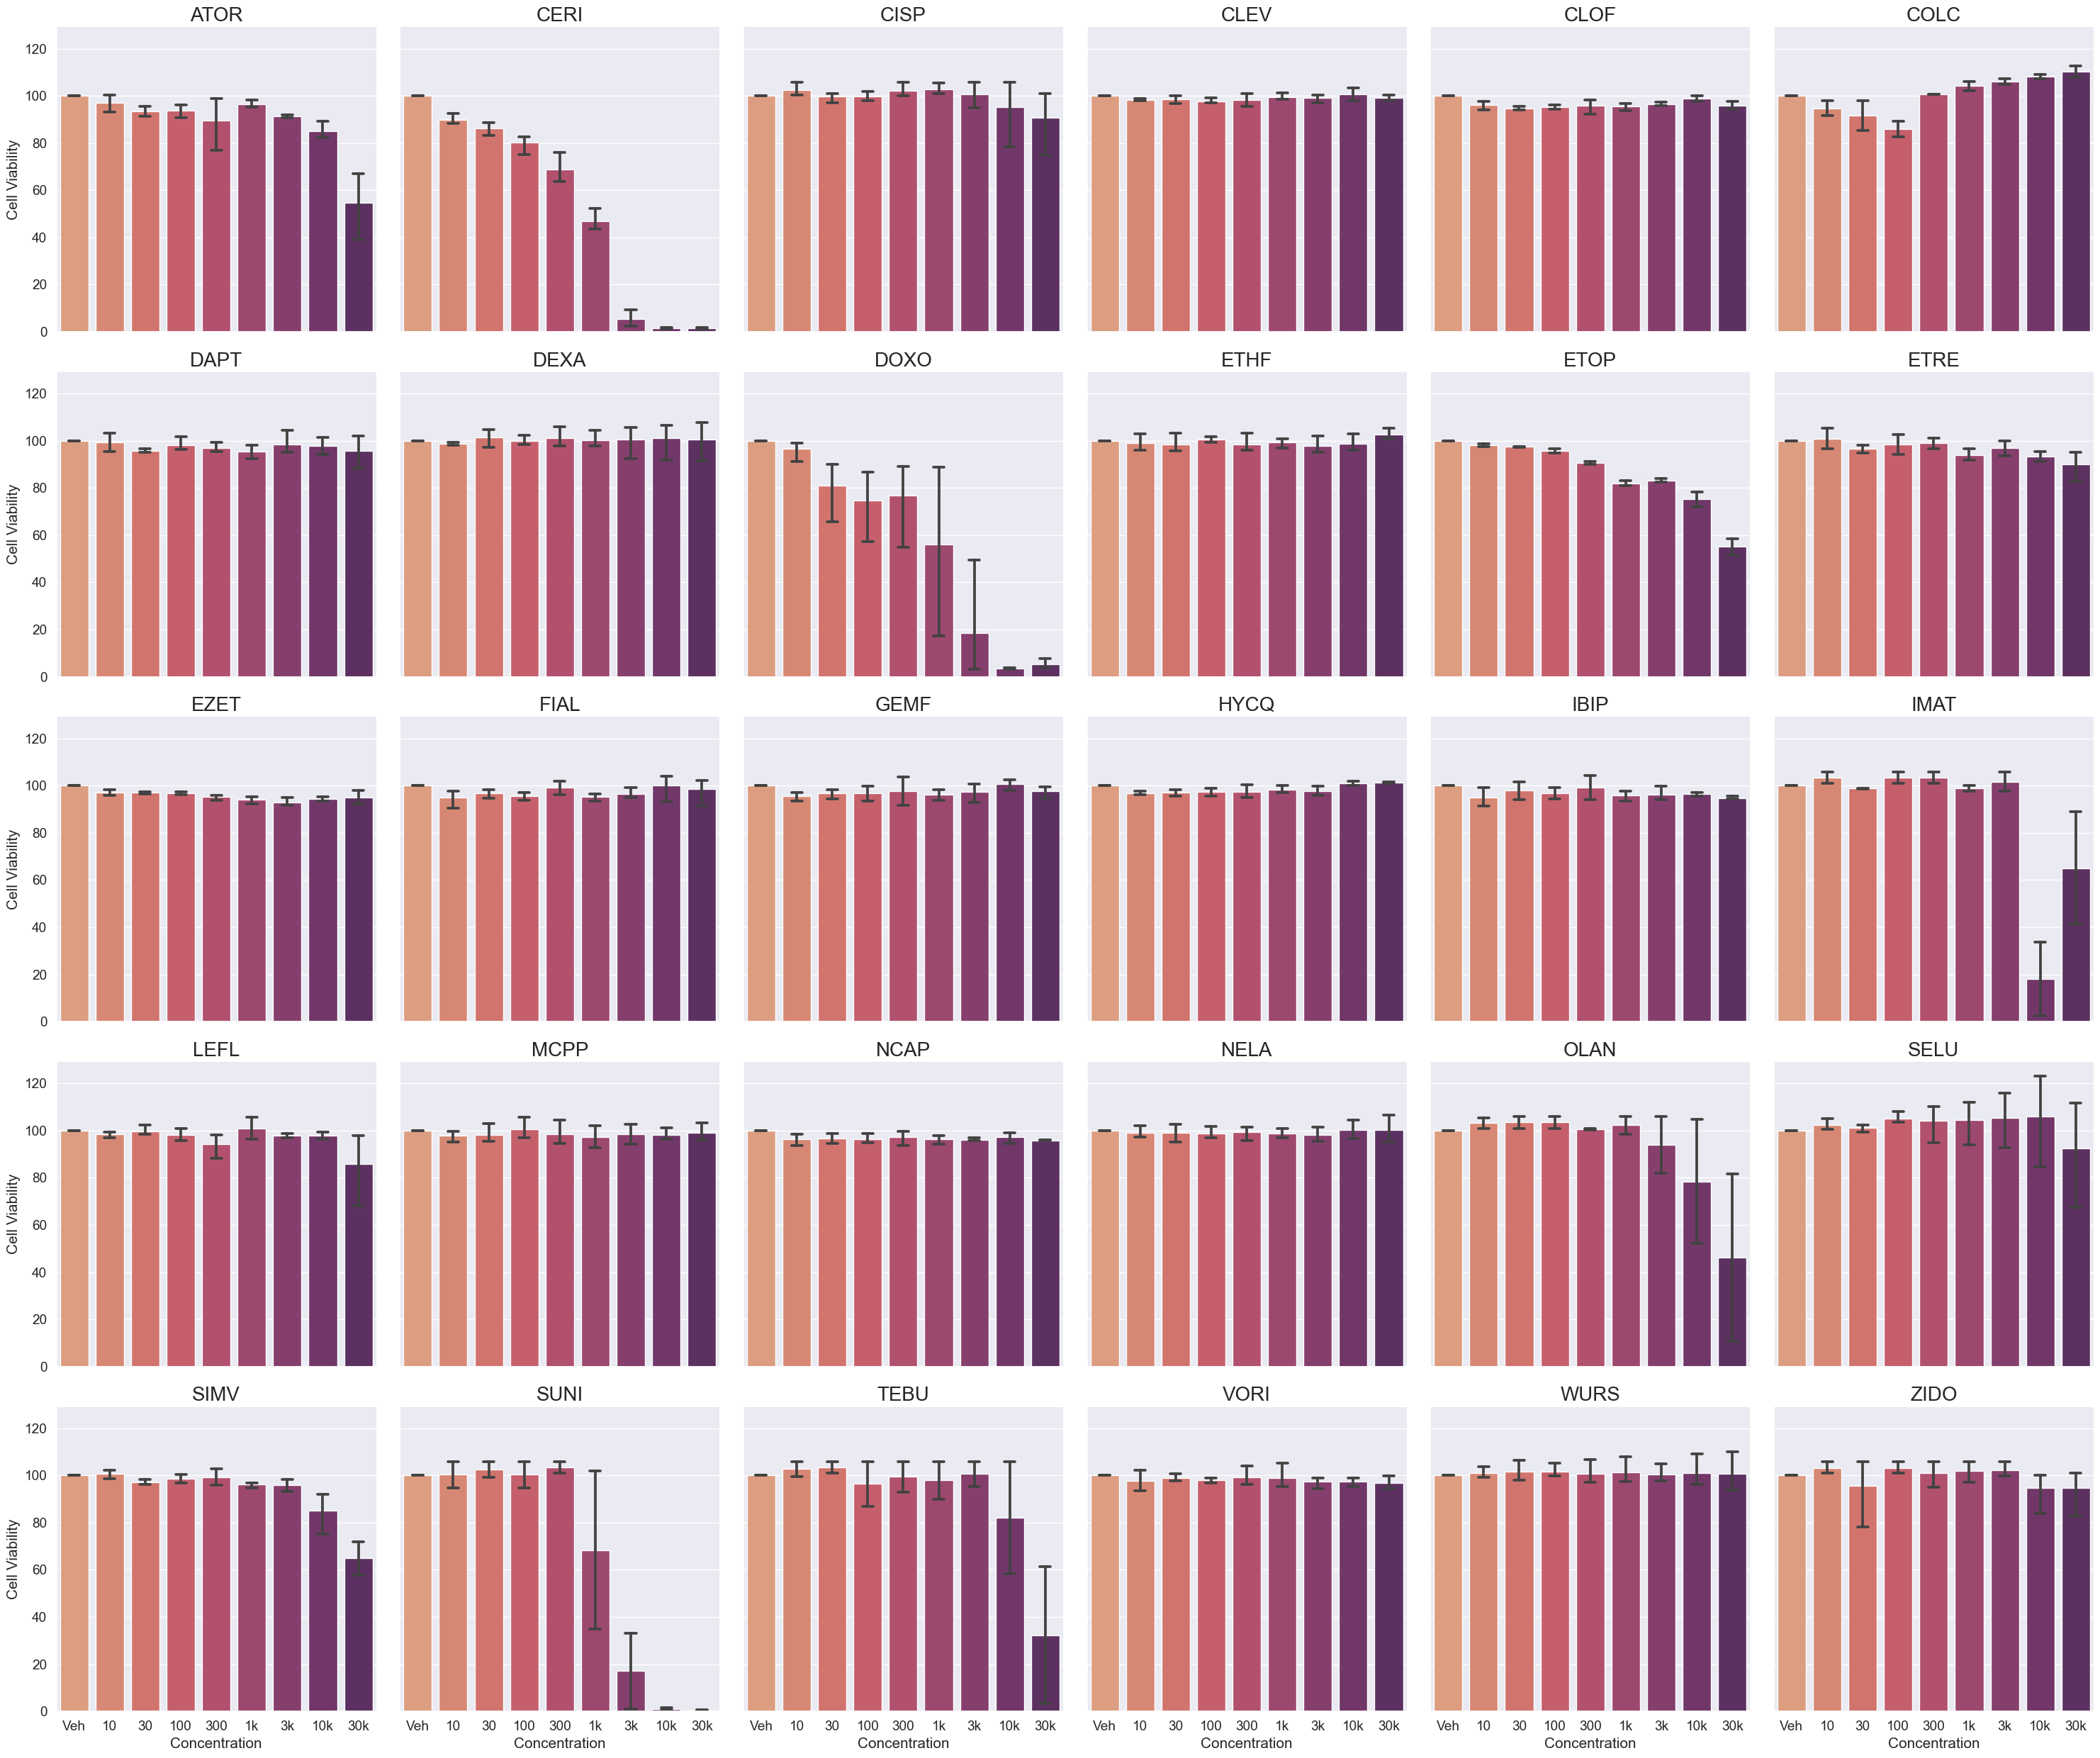

In [31]:
plotCTG = sns.catplot(  data=CTGdata_with_dmso_as_drug, 
                        x='Concentration',
                        y="Cell Viability",
                        col='Compound',
                        kind='bar',
                        #hue='Replicate',
                        palette = 'flare',
                        col_wrap=6,
                        capsize=0.3 )
#plotCTG.set_xticklabels(labels= plotCTG.facet_axis rotation=30)
plotCTG.set_titles(row_template = '{row_name}', col_template = '{col_name}',size=18)
#plotCTG.tick_params(axis='x', labelrotation = 0)
plotCTG.set_xticklabels(['Veh','10','30','100','300','1k','3k','10k','30k'])
plotCTG.set_titles(col_template = '{col_name}',size=20)

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


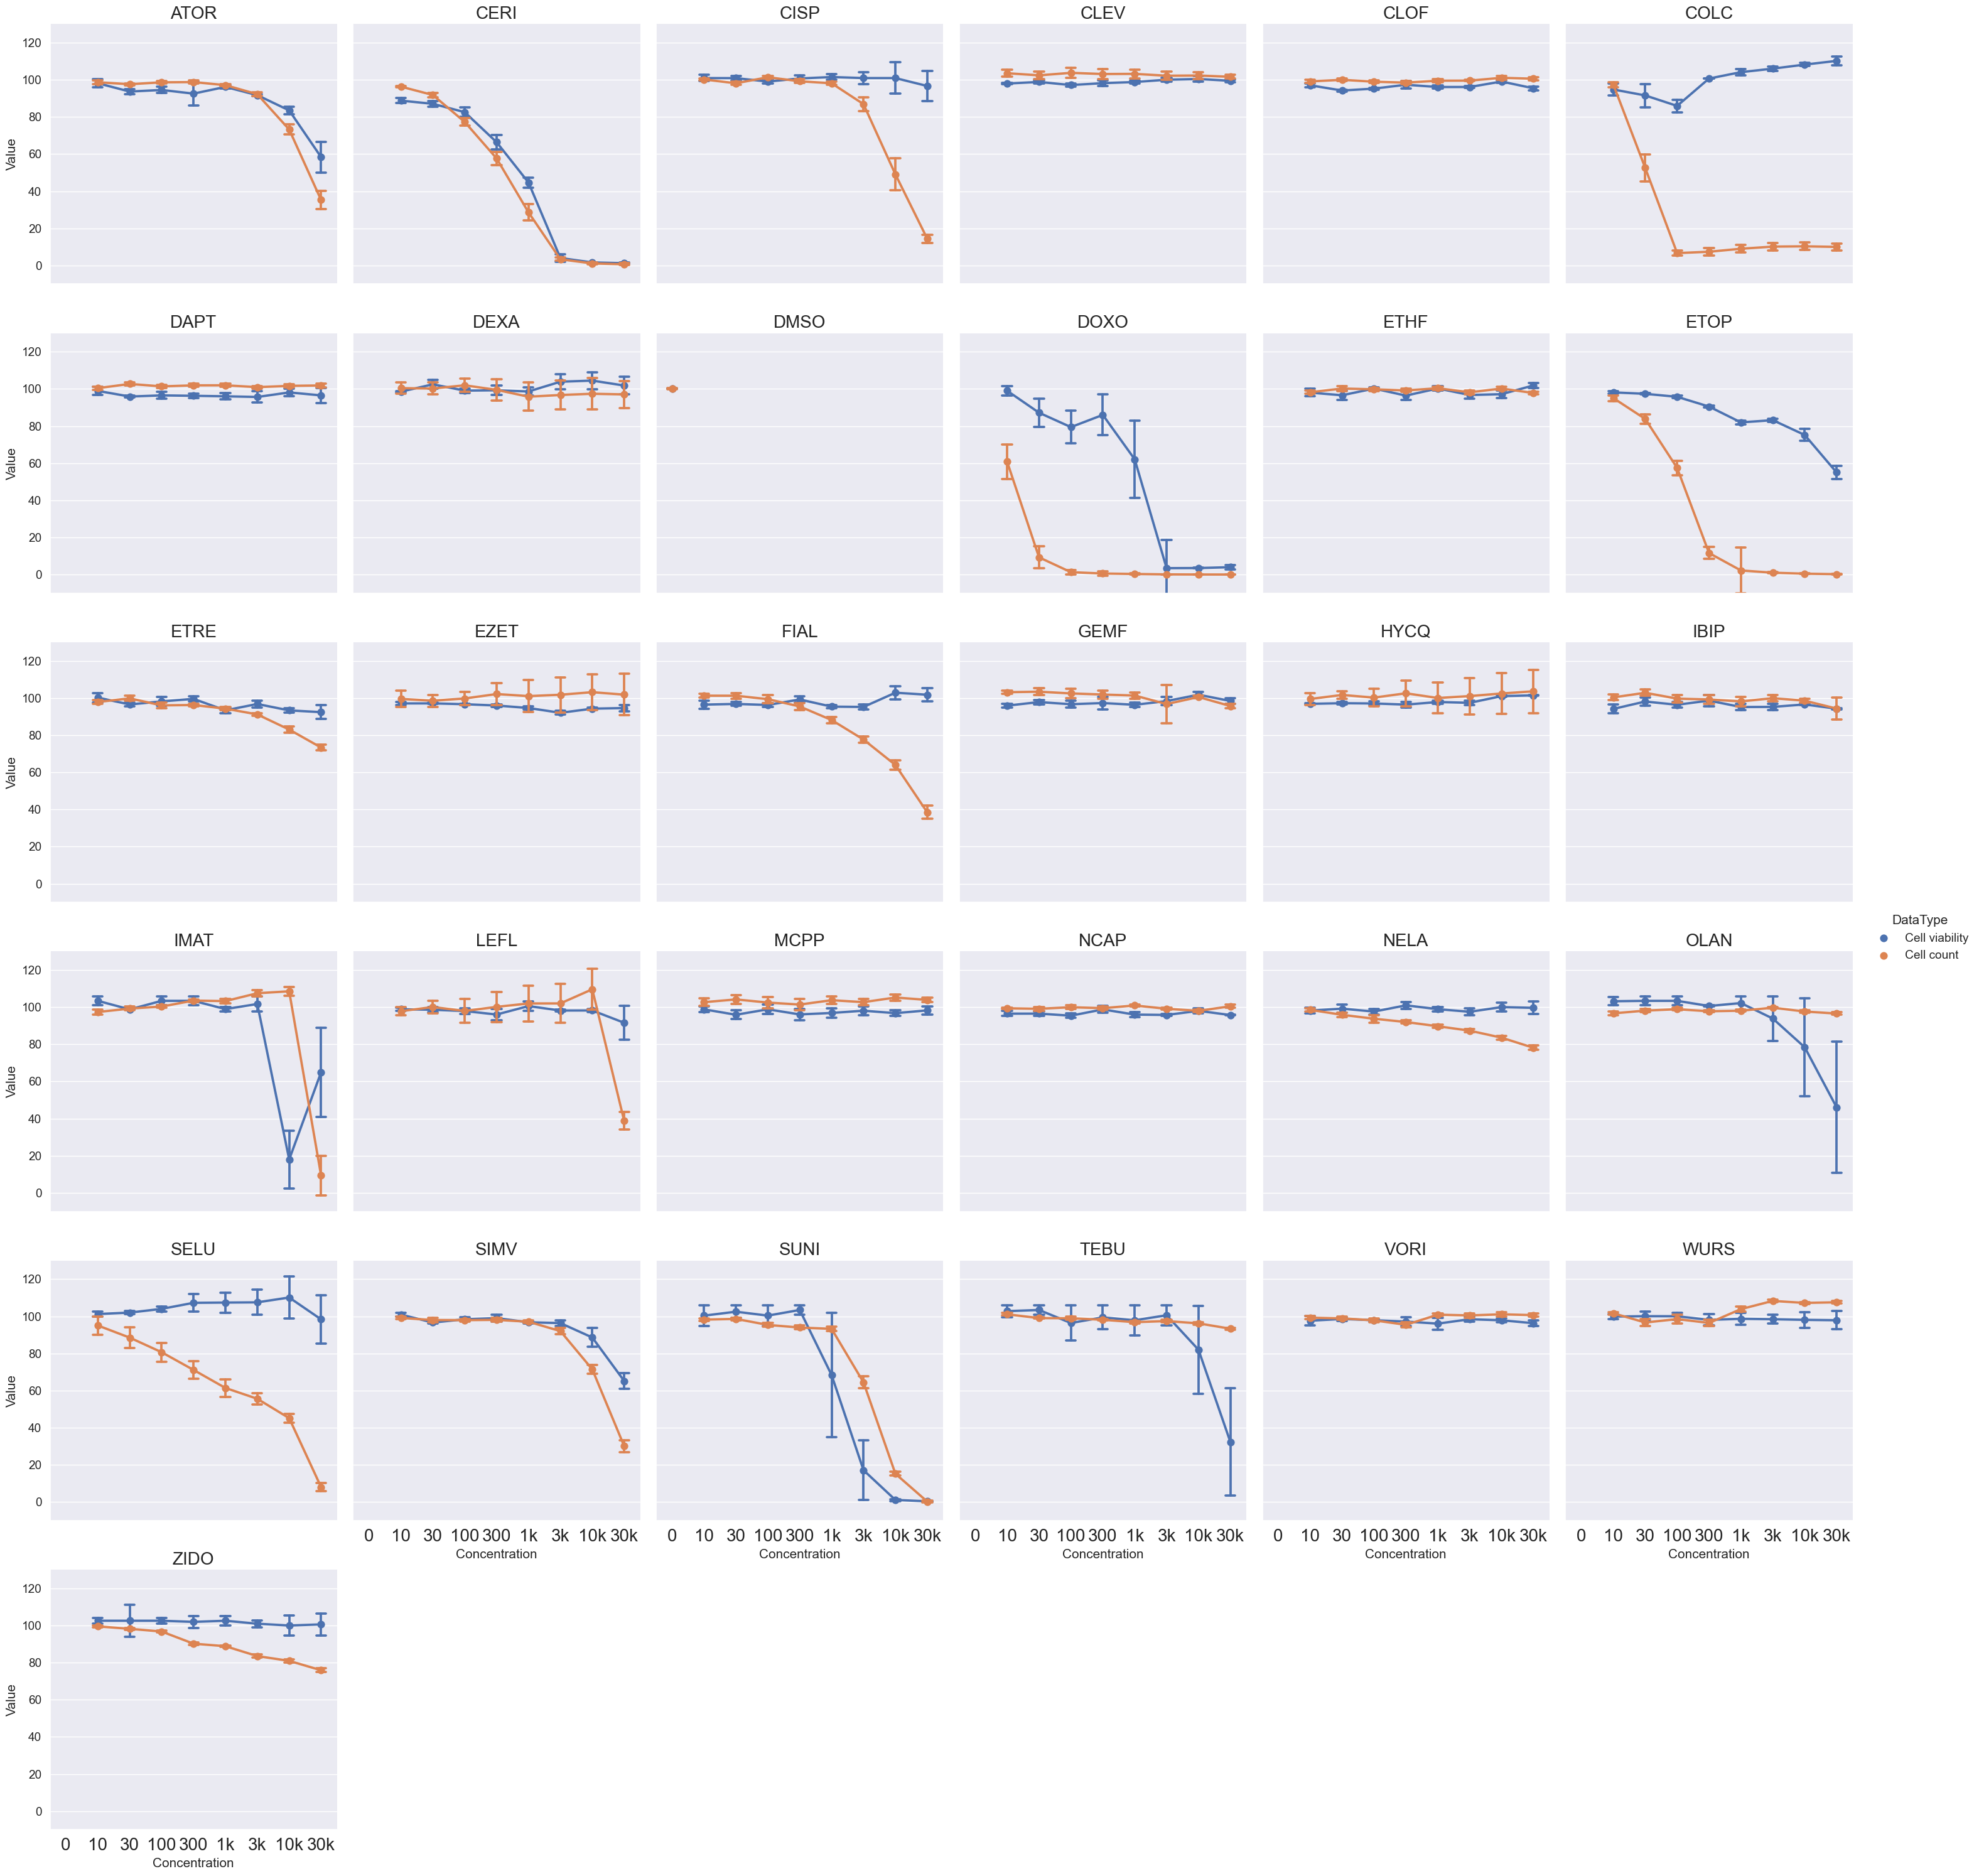

In [10]:
#superpose both plots
CTGdata.rename(columns={"Cell Viability":"Value", "Plate":"PlateName"},inplace=True)
cpdata.rename(columns={"Count":"Value"},inplace=True)
CTGandCP = pd.concat([CTGdata,cpdata],axis=0)

plotCTGandCP = sns.catplot( data=CTGandCP, 
                            estimator='median',
                            x='Concentration',
                            y="Value",
                            col='Compound',
                            hue='DataType',
                            kind='point',
                            col_wrap=6,
                            capsize=0.3,
                            errorbar='se',
)
plotCTGandCP.set_titles(row_template = '{row_name}', col_template = '{col_name}',size=18)
plotCTGandCP.set_xticklabels(fontdict={'fontsize':20})
plotCTGandCP.set_xticklabels(['0','10','30','100','300','1k','3k','10k','30k'])
plotCTGandCP.set_titles(col_template = '{col_name}',size=20)
plotCTGandCP.set(ylim=(-10, 130))

In [11]:
# perform significance test between each treatment-concentration and plate DMSO controls
from scipy.stats import ttest_ind, f_oneway
from statsmodels.stats.multitest import multipletests
t_tests_cpa = []
for compound in cp_data_with_dmso_as_drug.Compound.unique():
    compound_df = cp_data_with_dmso_as_drug.loc[cp_data_with_dmso_as_drug['Compound']==compound]
    for concentration in compound_df.Concentration.unique():
        if concentration > 0:
            treatment = compound_df.loc[compound_df['Concentration']==concentration]
            controls = compound_df.loc[compound_df['Concentration']==0].groupby(by=['PlateName']).mean(numeric_only=True)
            test = ttest_ind(treatment['Count'],controls['Count'])
            anova = f_oneway(treatment['Count'],controls['Count'])
            t_tests_cpa.append((compound,concentration,test[0],test[1], anova[0],anova[1]))

test_summary = pd.DataFrame(t_tests_cpa, columns=['Compound','Concentration','t-stat','p-value', 'F-stat','p-value anova'])
# count number of unique compounds with p-value < 0.05
test_summary.loc[test_summary['p-value']<0.05].Compound.unique()

array(['ATOR', 'CERI', 'CISP', 'COLC', 'DOXO', 'ETOP', 'ETRE', 'FIAL',
       'IMAT', 'LEFL', 'NELA', 'OLAN', 'SELU', 'SIMV', 'SUNI', 'TEBU',
       'WURS', 'ZIDO'], dtype=object)

In [12]:
t_tests_ctg = []
for compound in CTGdata_with_dmso_as_drug.Compound.unique():
    compound_df = CTGdata_with_dmso_as_drug.loc[CTGdata_with_dmso_as_drug['Compound']==compound]
    for concentration in compound_df.Concentration.unique():
        if concentration > 0:
            treatment = compound_df.loc[compound_df['Concentration']==concentration]
            controls = compound_df.loc[compound_df['Concentration']==0].groupby(by=['Plate']).mean(numeric_only=True)
            test = ttest_ind(treatment['Cell Viability'],controls['Cell Viability'])
            anova = f_oneway(treatment['Cell Viability'],controls['Cell Viability'])
            t_tests_ctg.append((compound,concentration,test[0],test[1], anova[0],anova[1]))

test_summary = pd.DataFrame(t_tests_ctg, columns=['Compound','Concentration','t-stat','p-value', 'F-stat','p-value anova'])
test_summary.sort_values(by='p-value')

c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurre

,Compound,Concentration,t-stat,p-value,F-stat,p-value anova
14,CERI,10000.0,-737.040182,2.033205e-11,543228.230522,2.033205e-11
70,DOXO,10000.0,-499.125480,9.667199e-11,249126.244911,9.667199e-11
15,CERI,30000.0,-404.970759,2.230689e-10,164001.315308,2.230689e-10
71,DOXO,30000.0,-73.655010,2.036144e-07,5425.060441,2.036144e-07
13,CERI,3000.0,-45.752406,1.364940e-06,2093.282685,1.364940e-06
...,...,...,...,...,...,...
202,SUNI,100.0,0.064722,9.542826e-01,0.004189,9.542826e-01
200,SUNI,10.0,0.062130,9.561101e-01,0.003860,9.561101e-01
60,DEXA,1000.0,0.035985,9.730182e-01,0.001295,9.730182e-01
58,DEXA,100.0,-0.012312,9.907667e-01,0.000152,9.907667e-01


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliab

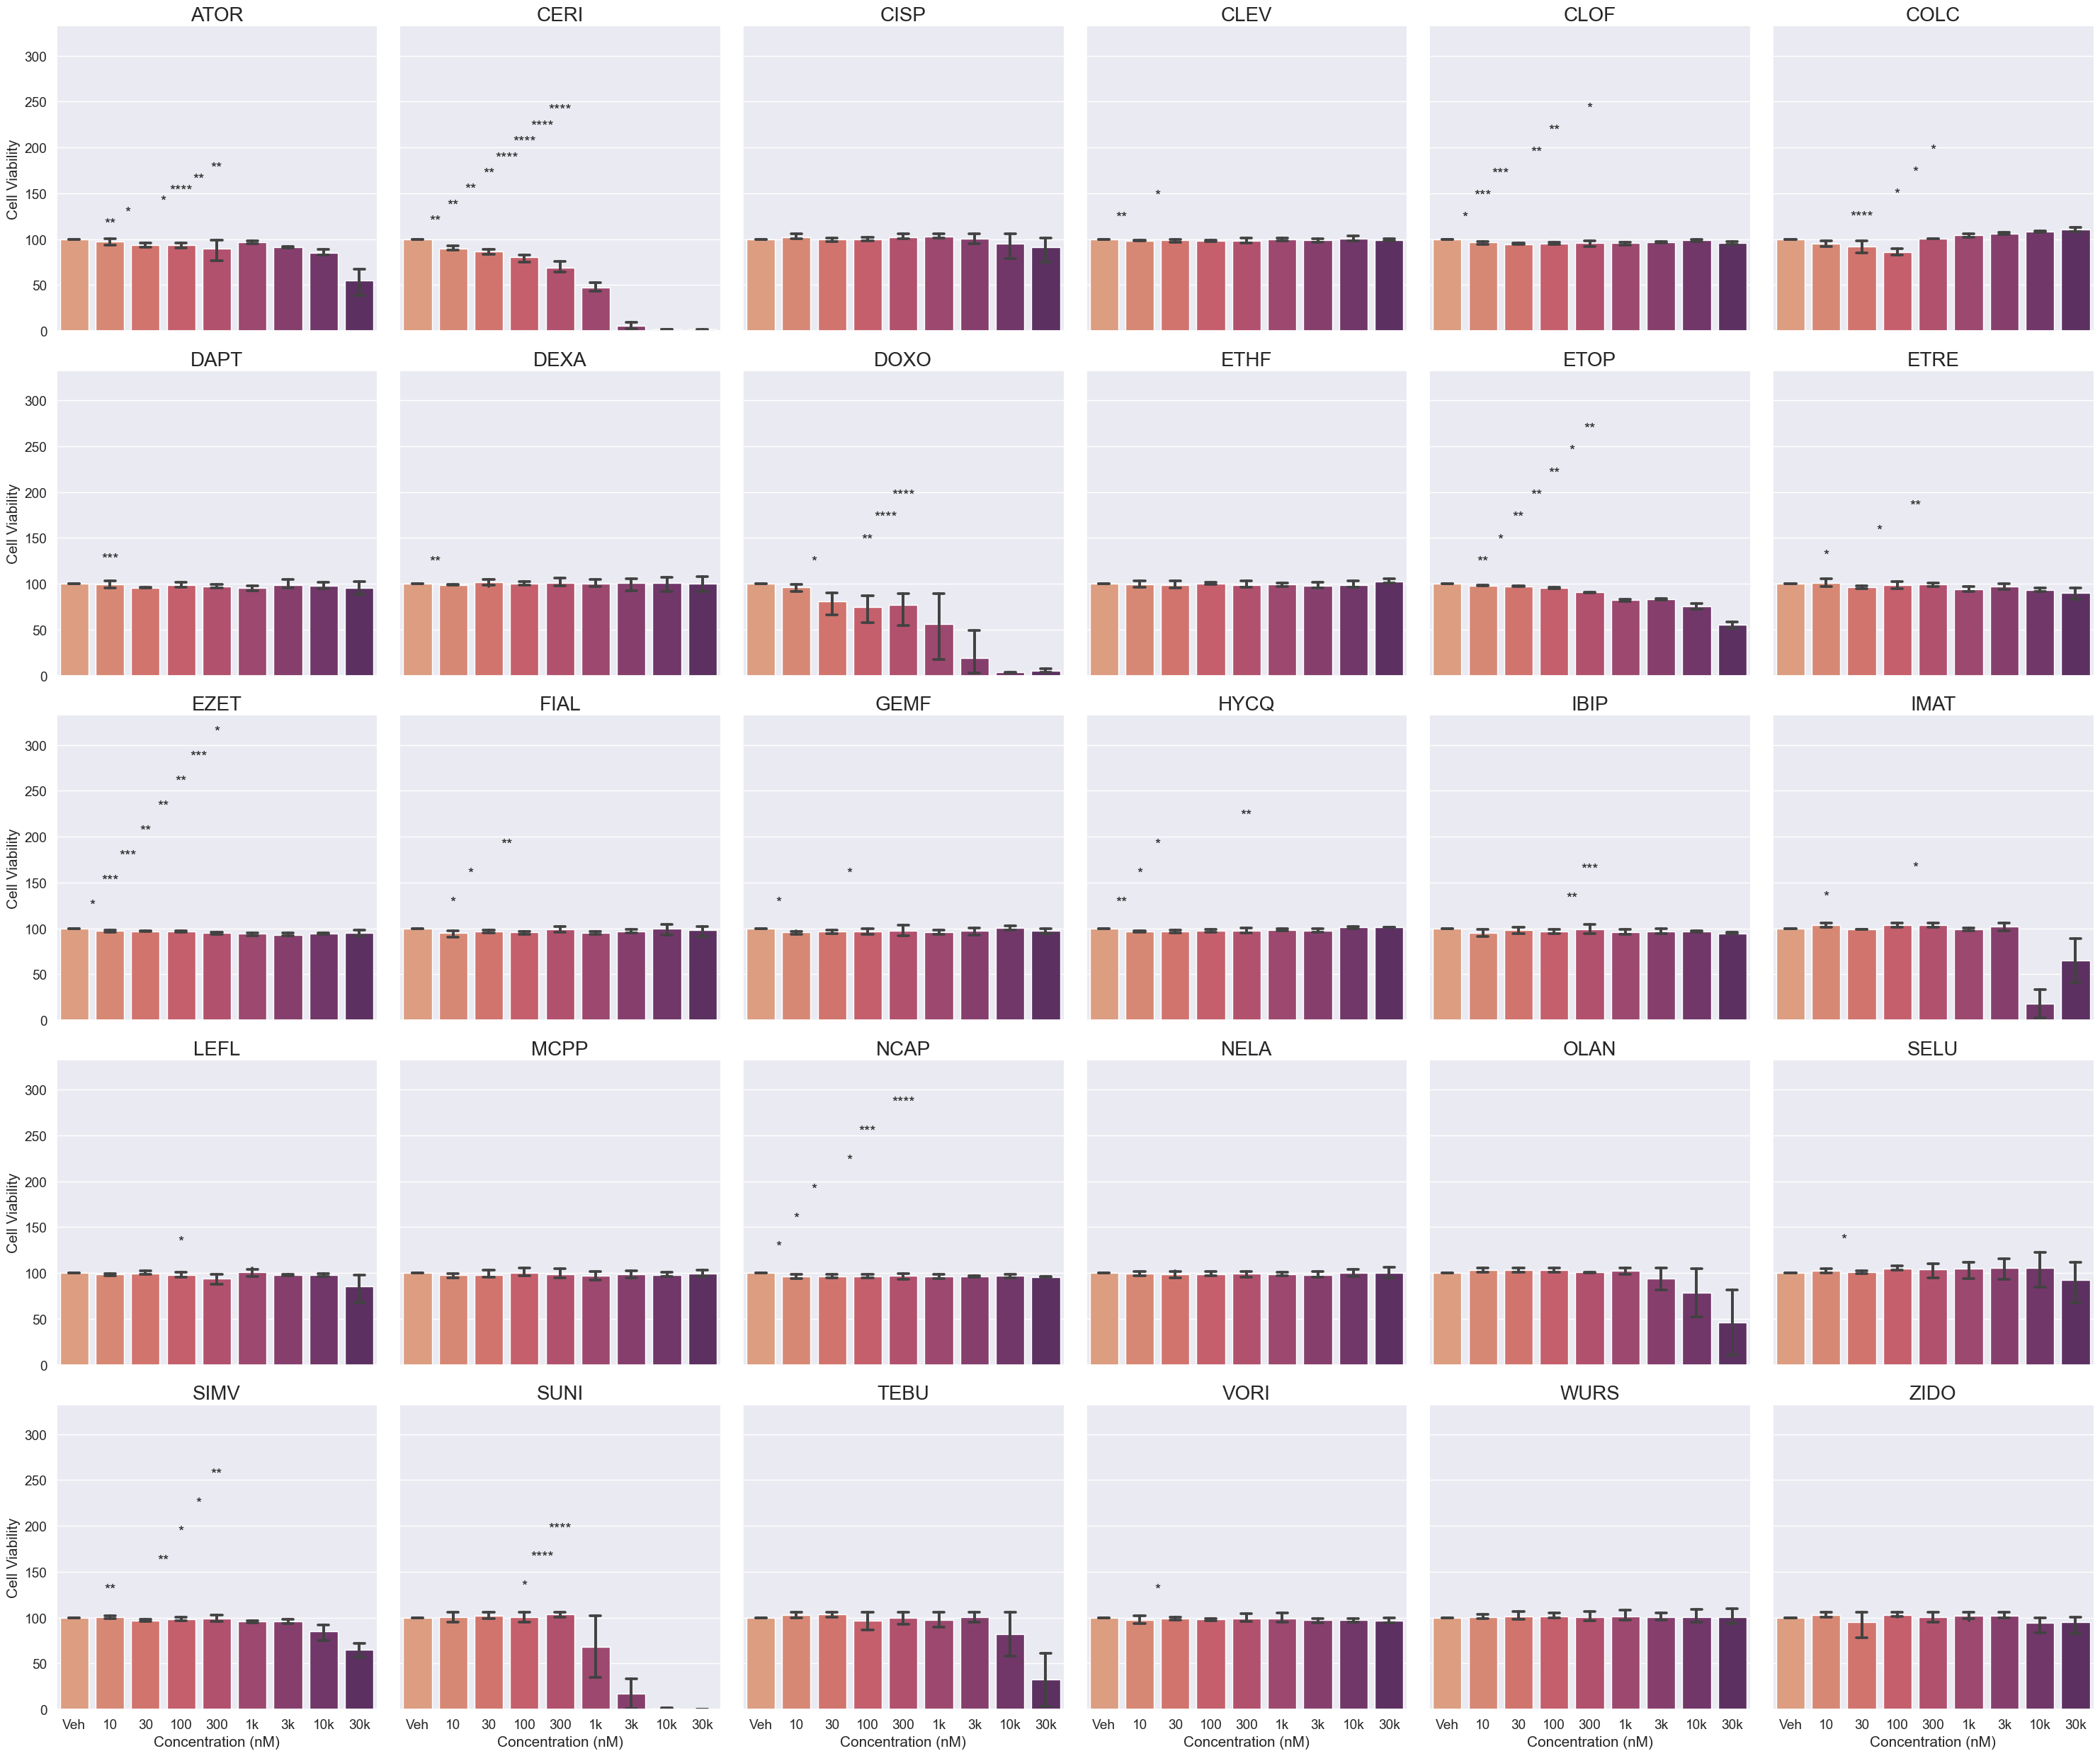

In [28]:
from statannotations.Annotator import Annotator

plotCTG = sns.catplot(  data=CTGdata_with_dmso_as_drug, 
                        x='Concentration',
                        y="Cell Viability",
                        col='Compound',
                        kind='bar',
                        #hue='Replicate',
                        col_wrap=6,
                        capsize=0.3 )
pairs=[
        (0.0, 30000.0), 
        (0.0, 10000.0),
        (0.0, 3000.0),
        (0.0, 1000.0),
        (0.0, 300.0),
        (0.0, 100.0),
        (0.0, 30.0),
        (0.0, 10.0),
       ]
ant = Annotator(None, pairs)
kwargs = {
    'plot_params': { # this takes what normally goes into sns.barplot etc.
        'x': 'Concentration',
        'y': 'Cell Viability',
        'palette': 'flare',
    },
    'annotation_func': 'apply_test', # has three options
    'configuration': {'test': 't-test_ind', 
                      'hide_non_significant': True, 
                      'verbose': False,
                      'loc': 'inside',
                      'line_offset': 0,
                    'line_height': 0,
                    'line_width': 0,
                      }, # this takes what normally goes into ant.configure
    'plot': 'barplot'
}

plotCTG.map_dataframe(ant.plot_and_annotate_facets, **kwargs)
#plotCTG.set_xticklabels(labels= plotCTG.facet_axis rotation=30)
plotCTG.set_titles(row_template = '{row_name}', col_template = '{col_name}',size=18)
# change the x axis title to Concentration (nM)
plotCTG.set_xlabels('Concentration (nM)')
#plotCTG.tick_params(axis='x', labelrotation = 0)
plotCTG.set_xticklabels(['Veh','10','30','100','300','1k','3k','10k','30k'])
plotCTG.set_titles(col_template = '{col_name}',size=20)